In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, LeakyReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.data import Dataset
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
import cv2

In [444]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape(x_train.shape[0], 28, 28)

In [445]:
x_train_new=numpy.zeros((6000,20,20), int)
nb_images_added=0
for image, y_t in enumerate(y_train):
    if y_t==0:
        x_train_new[nb_images_added]=cv2.resize(x_train[image], (20,20))
        nb_images_added+=1

In [446]:
x_train_new=x_train_new[0:5000]

In [447]:
len(x_train_new)

5000

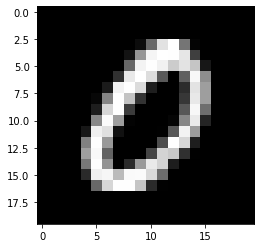

In [448]:
plt.imshow(x_train_new[4000], cmap="gray")

In [449]:
x_train=x_train_new.reshape(x_train_new.shape[0], 20, 20, 1)
x_train=(x_train-127.5)/127.5

In [450]:
BUFFER_SIZE=x_train.shape[0]
BATCH_SIZE=5
train_dataset=Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [479]:
def make_discriminator_model():
    model=Sequential()
    model.add(Conv2D(9, (3, 3), padding="same", input_shape=(20,20,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(6, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(30, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [480]:
model_discriminator=make_discriminator_model()
model_discriminator(numpy.random.rand(1,20,20,1).astype("float32"))
discriminator_optimizer=Adam(5e-7)

In [481]:
cross_entropy_d=tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy_g=tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [482]:
def get_discriminator_loss(real_predictions, fake_predictions):
    real_predictions=tf.sigmoid(real_predictions-0.1)
    fake_predictions=tf.sigmoid(fake_predictions+0.1)
    real_loss=cross_entropy_d(tf.ones_like(real_predictions), real_predictions)
    fake_loss=cross_entropy_d(tf.zeros_like(fake_predictions),fake_predictions)
    return (fake_loss+real_loss)/2

In [483]:
#Generator
def make_generator_model():
    model=Sequential()
    model.add(Dense(5*5*32, use_bias=False, input_shape=(20,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((5, 5, 32)))
    model.add(Conv2DTranspose(8, (3, 3),strides=(1,1), padding="same", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(4, (3, 3), strides=(2, 2), padding="same", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    #model.add(Flatten())
    #model.add(Dense(100, activation="tanh", use_bias=False))
    #assert model.output_shape==(None, 10, 10, 1)
    return model

In [484]:
generator=make_generator_model()
generator_optimizer=Adam(5e-3)

In [485]:
image=tf.reshape(generator((numpy.random.randn(1,20))*127)+127, (-1))

In [486]:
image.shape

TensorShape([400])

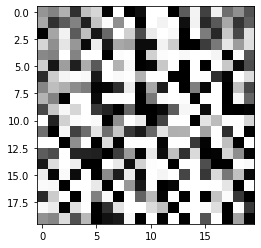

In [487]:
plt.imshow(tf.reshape((image*127)+127,(20,20)), cmap="gray")

In [488]:
def get_generator_loss(fake_predictions):
    #fake_predictions=tf.sigmoid(fake_predictions)
    fake_loss=cross_entropy_g(tf.ones_like(fake_predictions), fake_predictions+0.1)
    return fake_loss

In [491]:
#Training
def train(dataset, epochs):
    e=0
    for _ in range(epochs):
        e+=1
        b=0
        print("epochs", e)
        for images in dataset:
            images=tf.cast(images, tf.dtypes.float32)
            gen, disc=train_step(images)
            b+=1
            if b%200==0:
                print("batches", b)
                print("G: ", gen)
                print("D: ", disc)

In [492]:
#@tf.function
def train_step(images):
    fake_images_noise=numpy.random.randn(BATCH_SIZE, 20).astype("float32")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images=generator(fake_images_noise, training=True)
        generated_images=tf.reshape(generated_images, (-1, 20, 20, 1))
        
        real_output=model_discriminator(images, training=True)
        fake_output=model_discriminator(generated_images, training=True)

        gen_loss=get_generator_loss(fake_output)
        disc_loss=get_discriminator_loss(real_output, fake_output)

        gradient_of_generator=gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator=disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, model_discriminator.trainable_variables))

    gen=numpy.mean(gen_loss)
    disc=numpy.mean(disc_loss)

    return gen, disc 

In [463]:
train(train_dataset, 10)

epochs 1
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 2
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 3
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 4
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 5
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 6
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 7
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 8
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 9
batches 200
batches 400
batches 600
batches 800
batches 1000
epochs 10
batches 200
batches 400
batches 600
batches 800
batches 1000


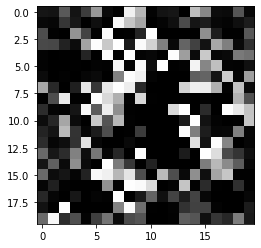

In [475]:
plt.imshow(tf.reshape(image, (20,20)), cmap="gray")

In [1]:
image=generator((numpy.random.randn(1,20)))

NameError: name 'generator' is not defined

In [474]:
tf.sigmoid(model_discriminator(image))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.91068083]], dtype=float32)>

In [424]:
image=x_train[10]

In [425]:
image=tf.reshape(image, (1, 20, 20, 1))